In [2]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('datanew2.csv')

In [4]:
df['late'] = df['days_for_shipping_(real)'] > df['days_for_shipment_(scheduled)']

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score


# Define features and target variable
features = ['type', 'days_for_shipment_(scheduled)', 'shipping_mode', 
            'order_country', 'order_status', 'benefit_per_order', 
            'sales_per_customer', 'customer_city', 'customer_state', 
            'category_name', 'product_price', 'latitude', 'longitude']
target = 'late'

X = df[features]
y = df[target]

# Preprocess the data
categorical_features = ['type', 'shipping_mode', 'order_country', 'order_status', 
                        'customer_city', 'customer_state', 'category_name']
numerical_features = ['days_for_shipment_(scheduled)', 'benefit_per_order', 
                      'sales_per_customer', 'product_price', 'latitude', 'longitude']

# One-hot encode categorical variables and scale numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)
X_processed = preprocessor.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))


Classification Report:
               precision    recall  f1-score   support

       False       0.73      0.83      0.78      5345
        True       0.86      0.77      0.81      7101

    accuracy                           0.80     12446
   macro avg       0.79      0.80      0.79     12446
weighted avg       0.80      0.80      0.80     12446

ROC AUC Score: 0.8797681429077103


In [6]:
from sklearn.linear_model import LogisticRegression

# Define the simplified features
simplified_features = ['shipping_mode', 'type', 'order_country']

# Align indices of features and labels
simplified_X = X.loc[y_train.index, simplified_features]

# Define a new preprocessor for the simplified dataset
simplified_categorical_features = ['shipping_mode', 'type', 'order_country']
simplified_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), simplified_categorical_features)
    ]
)

# Transform the simplified dataset
simplified_X_processed = simplified_preprocessor.fit_transform(simplified_X)

# Train the logistic regression model
simplified_model = LogisticRegression(max_iter=500, class_weight='balanced')
simplified_model.fit(simplified_X_processed, y_train)

# Evaluate the simplified model
y_pred_simplified = simplified_model.predict(simplified_X_processed)
print("Simplified Model Performance:")
print(classification_report(y_train, y_pred_simplified))

Simplified Model Performance:
              precision    recall  f1-score   support

       False       0.59      0.90      0.71     21229
        True       0.88      0.53      0.66     28554

    accuracy                           0.69     49783
   macro avg       0.74      0.72      0.69     49783
weighted avg       0.76      0.69      0.69     49783



In [7]:
from sklearn.metrics import precision_recall_curve, roc_curve

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_train, simplified_model.predict_proba(simplified_X_processed)[:, 1])

# Find the optimal threshold (maximizing F1-Score)
optimal_threshold = None
max_f1 = 0
for p, r, t in zip(precision, recall, thresholds):
    f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
    if f1 > max_f1:
        max_f1 = f1
        optimal_threshold = t

print(f"Optimal Threshold: {optimal_threshold}, Max F1: {max_f1}")

# Apply the optimal threshold
y_pred_optimized = (simplified_model.predict_proba(simplified_X_processed)[:, 1] >= optimal_threshold).astype(int)

# Evaluate with the optimal threshold
from sklearn.metrics import classification_report
print("Performance with Optimal Threshold:")
print(classification_report(y_train, y_pred_optimized))

Optimal Threshold: 0.3155184781833185, Max F1: 0.7302880264068572
Performance with Optimal Threshold:
              precision    recall  f1-score   support

       False       0.65      0.10      0.17     21229
        True       0.59      0.96      0.73     28554

    accuracy                           0.59     49783
   macro avg       0.62      0.53      0.45     49783
weighted avg       0.62      0.59      0.49     49783



In [8]:
# Train a baseline model (e.g., Decision Tree Classifier)
from sklearn.tree import DecisionTreeClassifier

baseline_model = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')
baseline_model.fit(simplified_X_processed, y_train)

# Evaluate the baseline model
baseline_y_pred = baseline_model.predict(simplified_X_processed)
print("Baseline Model Performance:")
print(classification_report(y_train, baseline_y_pred))

Baseline Model Performance:
              precision    recall  f1-score   support

       False       0.59      0.90      0.71     21229
        True       0.88      0.54      0.67     28554

    accuracy                           0.69     49783
   macro avg       0.74      0.72      0.69     49783
weighted avg       0.76      0.69      0.69     49783



Optimal Threshold (Balanced Classes): 0.45451189375164375, Max Avg F1: 0.8020630306699034
Final Model Performance with Balanced Threshold:
              precision    recall  f1-score   support

       False       0.59      0.90      0.72     26574
        True       0.88      0.54      0.67     35655

    accuracy                           0.69     62229
   macro avg       0.74      0.72      0.69     62229
weighted avg       0.76      0.69      0.69     62229

ROC AUC Score: 0.7445080251898064


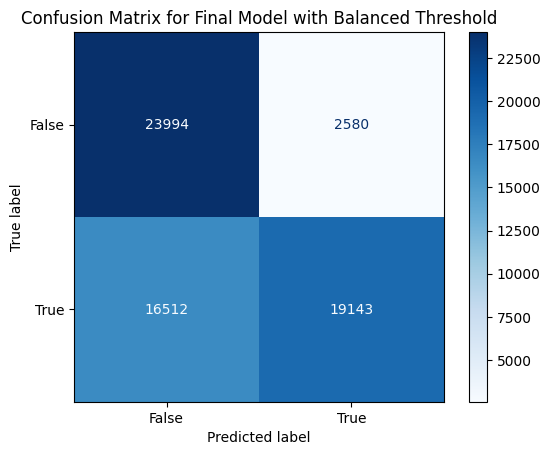

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, precision_recall_curve, roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay

# Define the simplified features and categorical preprocessing
simplified_features = ['shipping_mode', 'type', 'order_country']
simplified_categorical_features = simplified_features

# Create a preprocessing pipeline for simplified features
simplified_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), simplified_categorical_features)
    ]
)

# Train the final logistic regression model
final_model_pipeline = Pipeline(steps=[
    ('preprocessor', simplified_preprocessor),
    ('classifier', LogisticRegression(max_iter=500, class_weight='balanced', random_state=42))
])

final_model_pipeline.fit(X[simplified_features], y)

# Calculate the optimal threshold based on F1-score for balanced classes
precision, recall, thresholds = precision_recall_curve(y, final_model_pipeline.predict_proba(X[simplified_features])[:, 1])
optimal_threshold = None
max_avg_f1 = 0

for p, r, t in zip(precision, recall, thresholds):
    f1_false = 2 * (p * recall[0]) / (p + recall[0]) if (p + recall[0]) > 0 else 0  # F1 for False (On-Time)
    f1_true = 2 * (p * r) / (p + r) if (p + r) > 0 else 0  # F1 for True (Late)
    avg_f1 = (f1_false + f1_true) / 2  # Average F1 score for both classes
    
    if avg_f1 > max_avg_f1:
        max_avg_f1 = avg_f1
        optimal_threshold = t

print(f"Optimal Threshold (Balanced Classes): {optimal_threshold}, Max Avg F1: {max_avg_f1}")

# Evaluate the final model with the balanced optimal threshold
y_pred_final = (final_model_pipeline.predict_proba(X[simplified_features])[:, 1] >= optimal_threshold).astype(int)
print("Final Model Performance with Balanced Threshold:")
print(classification_report(y, y_pred_final))
print("ROC AUC Score:", roc_auc_score(y, final_model_pipeline.predict_proba(X[simplified_features])[:, 1]))

import matplotlib.pyplot as plt

# Plot the confusion matrix with consistent color
ConfusionMatrixDisplay.from_predictions(y, y_pred_final, cmap='Blues')
plt.title("Confusion Matrix for Final Model with Balanced Threshold")
plt.show()

In [35]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy
accuracy = accuracy_score(y, y_pred_final)

# Print the accuracy
print(f"Prediction Accuracy: {accuracy:.2f}")

Prediction Accuracy: 0.69


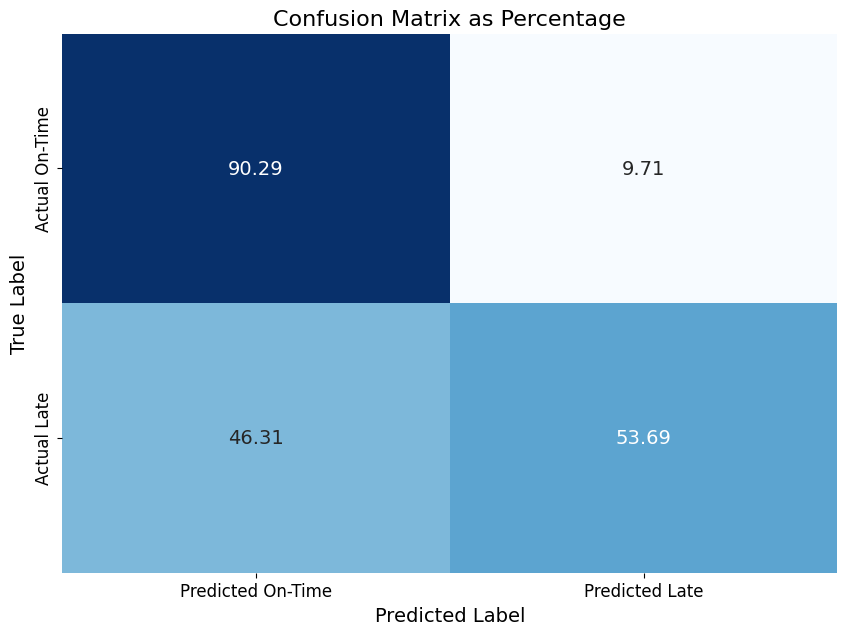

In [34]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(y, y_pred_final)

# Convert the confusion matrix to percentages
conf_matrix_percentage = conf_matrix / conf_matrix.sum(axis=1, keepdims=True) * 100

# Create a DataFrame to display the results
conf_matrix_df = pd.DataFrame(
    conf_matrix_percentage,
    index=['Actual On-Time', 'Actual Late'],
    columns=['Predicted On-Time', 'Predicted Late']
)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_df, annot=True, fmt=".2f", cmap="Blues", cbar=False,
            annot_kws={"size": 14})  # Increase font size for better readability
plt.title("Confusion Matrix as Percentage", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


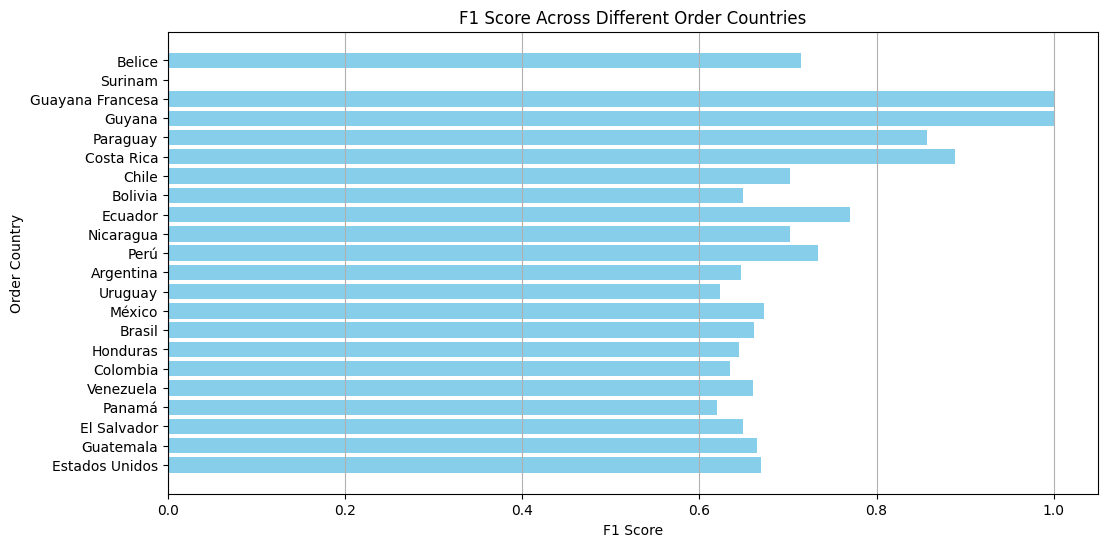

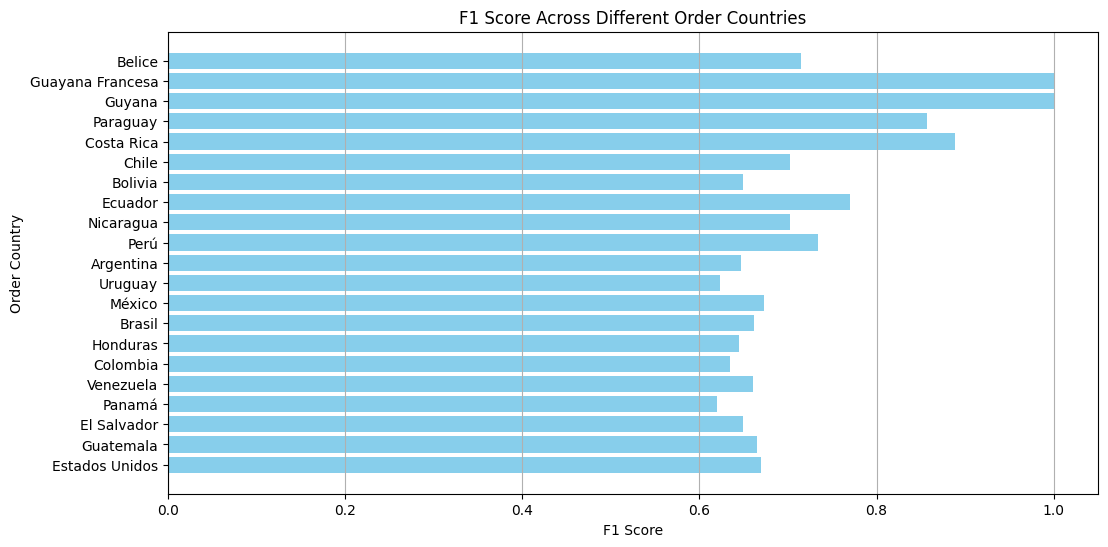

In [22]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Calculate F1 scores for each country
country_f1_scores = {}
for country in countries:
    country_indices = df[df['order_country'] == country].index
    if len(country_indices) > 0:
        y_true_country = y.loc[country_indices]
        y_pred_country = y_pred_final[country_indices]
        country_f1_scores[country] = f1_score(y_true_country, y_pred_country)

# Plot the F1 scores
plt.figure(figsize=(12, 6))
plt.barh(list(country_f1_scores.keys()), list(country_f1_scores.values()), color='skyblue')
plt.ylabel('Order Country')
plt.xlabel('F1 Score')
plt.title('F1 Score Across Different Order Countries')
plt.grid(axis='x')
plt.show()
# Remove Surinam from the country_f1_scores dictionary
if 'Surinam' in country_f1_scores:
    del country_f1_scores['Surinam']

# Plot the F1 scores with country on y-axis
plt.figure(figsize=(12, 6))
plt.barh(list(country_f1_scores.keys()), list(country_f1_scores.values()), color='skyblue')
plt.xlabel('F1 Score')
plt.ylabel('Order Country')
plt.title('F1 Score Across Different Order Countries')
plt.grid(axis='x')
plt.show()